In [70]:
from env import host, user, password

import numpy as np
import pandas as pd
import scipy as sp

from sqlalchemy import create_engine

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.tools.plotting import scatter_matrix
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter

## Acquisition

### Grab Data

1. Use the mysql connector to query telco_churn.customers. Assign the output of that query to the dataframe df. You want to include all the fields.

In [71]:
def get_db_url(
    hostname: str, username: str, password: str, db_name: str
) -> str:
    """
    return url for accessing a mysql database
    """
    return f"mysql+pymysql://{username}:{password}@{hostname}/{db_name}"


def get_sql_conn(hostname: str, username: str, password: str, db_name: str):
    """
    return a mysql connection object
    """
    return create_engine(get_db_url(host, user, password, db_name))


def df_from_sql(query: str, url: str) -> pd.DataFrame:
    """
    return a Pandas DataFrame resulting from a sql query
    """
    return pd.read_sql(query, url)


def get_telco_data() -> pd.DataFrame:
    db = "telco_churn"
    query = ("SELECT * "
             f"FROM customers;")
    url = get_db_url(host, user, password, db)
    return df_from_sql(query, url)

In [72]:
df = get_telco_data()

### Summarize Data

2. Write a function, peekatdata(dataframe), that takes a dataframe as input and computes and returns the following:

    - creates dataframe object head_df (df of the first 5 rows) and prints contents to screen
    - creates dataframe object tail_df (df of the last 5 rows) and prints contents to screen
    - creates tuple object shape_tuple (tuple of (nrows, ncols)) and prints tuple to screen
    - creates dataframe object describe_df (summary statistics of all numeric variables) and prints contents to screen.
    - prints to screen the information about a DataFrame including the index dtype and column dtypes, non-null values and memory usage.

In [73]:
def peekatdata(dataframe):
    head_df = dataframe.head()
    print(f"HEAD\n{head_df}", end="\n\n")

    tail_df = dataframe.tail()
    print(f"TAIL\n{tail_df}", end="\n\n")

    shape_tuple = dataframe.shape
    print(f"SHAPE: {shape_tuple}", end="\n\n")

    describe_df = dataframe.describe()
    print(f"DESCRIPTION\n{describe_df}", end="\n\n")

    print(f"INFORMATION")
    dataframe.info()

In [74]:
peekatdata(df)

HEAD
  customer_id  gender  senior_citizen partner dependents  tenure  \
0  0002-ORFBO  Female               0     Yes        Yes       9   
1  0003-MKNFE    Male               0      No         No       9   
2  0004-TLHLJ    Male               0      No         No       4   
3  0011-IGKFF    Male               1     Yes         No      13   
4  0013-EXCHZ  Female               1     Yes         No       3   

  phone_service multiple_lines  internet_service_type_id online_security  \
0           Yes             No                         1              No   
1           Yes            Yes                         1              No   
2           Yes             No                         2              No   
3           Yes             No                         2              No   
4           Yes             No                         2              No   

   ...  device_protection tech_support streaming_tv streaming_movies  \
0  ...                 No          Yes          Yes      

## Data Prep

### TODO
- [ ] multiple_lines has "No phone service" for the last row, which is not the same as yes/no that other columns have.
- [ ] convert total_charges column to float. it is an object after reading from sql database

1. Write a function, df_value_counts(dataframe), that takes a dataframe as input and computes and returns the values by frequency for each variable. Use the rule of thumb for your logic on whether or not to use the bins argument. The function will use a for loop and an in statement.

In [75]:
def df_value_counts(dataframe):
    for col in df.columns:
        n = df[col].unique().shape[0]
        col_bins = min(n, 10)
        print(f"{col}:")
        if df[col].dtype in ['int64', 'float64'] and n > 10:
            print(df[col].value_counts(bins=col_bins, sort=False))
        else:
            print(df[col].value_counts())
        print("\n")

In [76]:
df_value_counts(df)

customer_id:
4451-RWASJ    1
1135-LMECX    1
1169-SAOCL    1
4616-EWBNJ    1
7047-YXDMZ    1
8623-TMRBY    1
6993-OHLXR    1
8728-SKJLR    1
1481-ZUWZA    1
5997-OPVFA    1
4325-NFSKC    1
7693-QPEFS    1
3729-OWRVL    1
0813-TAXXS    1
7047-FWEYA    1
4936-YPJNK    1
6848-YLDFR    1
6727-IOTLZ    1
8975-SKGRX    1
7011-CVEUC    1
9754-CLVZW    1
3307-TLCUD    1
2607-FBDFF    1
3074-GQWYX    1
6963-KQYQB    1
6543-JXSOO    1
2325-NBPZG    1
8173-RXAYP    1
4855-SNKMY    1
0020-INWCK    1
             ..
5360-XGYAZ    1
7730-IUTDZ    1
0691-NIKRI    1
2682-KEVRP    1
2984-AFWNC    1
6906-MPARY    1
2157-MXBJS    1
9548-LIGTA    1
1213-NGCUN    1
4629-NRXKX    1
2279-AXJJK    1
3685-YLCMQ    1
6549-BTYPG    1
0644-OQMDK    1
5780-INQIK    1
2408-PSJVE    1
1031-IIDEO    1
5730-DBDSI    1
9927-DSWDF    1
6288-LBEAR    1
5569-OUICF    1
5032-USPKF    1
1565-RHDJD    1
5143-WMWOG    1
1087-UDSIH    1
4092-OFQZS    1
0871-URUWO    1
7544-ZVIKX    1
5216-WASFJ    1
1641-RQDAY    1
Name: custo

- customer_id has no duplicates
- gender is about even
- customers are mostly not seniors
- about equally split along single/partner
- most customers do not have dependents
- there are many new and many old customers
- overwhelming majority have phone service
- closely split along multiple_lines
- overwhelming majority have internet service
    - more have fiber than DSL
    - most do not have online_security
    - most do not have online_backup
    - most do not have device_protection
    - most do not have tech_support
- billing
    - about evenly split along streaming_tv
    - about evenly splot along streaming_movies
    - most customers are month-to-month
    - most customers are paperless billing
    - most customers pay by some form of check
    - many customers pay less than $30
    - most are pay between 45 and 110 per month
- most have not churned
    - about 1900 have
    

### Handle Missing Values

2. Missing Values:

    - Write a function, that returns a dataframe of the column name and the number of missing values and the percentage of missing values (missing records/total records) for each of the columns that have > 0 missing values.

   - Document your takeaways. For each variable:

        - should you remove the observations with a missing value for that variable?
        - should you remove the variable altogether?
        - is missing equivalent to 0 (or some other constant value) in the specific case of this variable?
        - should you replace the missing values with a value it is most likely to represent (e.g. Are the missing values a result of data integrity issues and should be replaced by the most likely value?)
        - Handle the missing values in the way you recommended above.

In [77]:
def df_missing_vals(dataframe):
    null_count = dataframe.isnull().sum()
    null_percentage = (null_count / dataframe.shape[0]) * 100
    empty_count = pd.Series(((dataframe == " ") | (dataframe == "")).sum())
    return pd.DataFrame({"nmissing": null_count, "percentage": null_percentage, "nempty": empty_count})

# test 
# print(df_missing_vals(pd.DataFrame({"col1": [np.nan, 1, "", np.nan, np.nan], "col2": [2, "", 4, np.nan, 4]})))

In [78]:
print(df_missing_vals(df))

                          nmissing  percentage  nempty
customer_id                      0         0.0       0
gender                           0         0.0       0
senior_citizen                   0         0.0       0
partner                          0         0.0       0
dependents                       0         0.0       0
tenure                           0         0.0       0
phone_service                    0         0.0       0
multiple_lines                   0         0.0       0
internet_service_type_id         0         0.0       0
online_security                  0         0.0       0
online_backup                    0         0.0       0
device_protection                0         0.0       0
tech_support                     0         0.0       0
streaming_tv                     0         0.0       0
streaming_movies                 0         0.0       0
contract_type_id                 0         0.0       0
paperless_billing                0         0.0       0
payment_ty

- **No columns have NaNs.**
- **total_charges has 11 observations with a " " or "" value**
- [x] ***let's replace the 11 with their monthly_charges * tenure***
- **The total_charges with " " all had tenure of 0 so they were essentially replaced with zeroes; neither the observations nor the variable do not have to be removed.**

Handle the missing values in the way you recommended above.

In [79]:
df['total_charges'] = np.where(df['total_charges'] == ' ', (df.monthly_charges * df.tenure), df['total_charges'])

3. Transform churn such that "yes" = 1 and "no" = 0

In [80]:
df['churn'] = df['churn'].map( {'No': 0, 'Yes': 1} ).astype(int)

4. Compute a new feature, tenure_year, that is a result of translating tenure from months to years.

In [81]:
df['tenure_year'] = df.tenure / 12

5. Figure out a way to capture the information contained in phone_service and multiple_lines into a single variable of dtype int. Write a function that will transform the data and place in a new column phone_id in df_sql. Be sure you have documented your function and logic well.

In [82]:
def add_phone_id(df):
    '''
    return DataFrame with a new colum phone_id that combines phone_service and multiple_lines as follows:
    
    # 0 = no phone service
    # 1 = One line
    # 2 = Two+ lines
    
    '''
    df_temp = df.copy()
    df_temp.loc[(df_temp.phone_service == 'No'), 'phone_id'] = 0
    df_temp.loc[(df_temp.phone_service == 'Yes') & (df_temp.multiple_lines == 'No'), 'phone_id'] = 1
    df_temp.loc[(df_temp.phone_service == 'Yes') & (df_temp.multiple_lines == 'Yes'), 'phone_id'] = 2
    df_temp = df_temp.astype({'phone_id': int})
    return df_temp

df_sql = add_phone_id(df)
# df_sql[['phone_service', 'multiple_lines', 'phone_id']].tail(10)

6. Figure out a way to capture the information contained in dependents and partner into a single variable of dtype int. Transform the data and place in a new column household_type_id in df_sql. Be sure you have documented your function and logic well.

In [83]:
def add_household_type_id(df):
    '''
    return DataFrame with a new colum household_type_id that combines partner and dependents as follows:
    
    # 0 = no partner, no dependents
    # 1 = has partner, no dependents
    # 2 = no partner, has dependents
    # 3 = has partner, has dependents
    
    '''
    df_temp = df.copy()
    df_temp.loc[(df_temp.partner == 'No')& (df_temp.dependents == 'No'), 'household_type_id'] = 0
    df_temp.loc[(df_temp.partner == 'Yes') & (df_temp.dependents == 'No'), 'household_type_id'] = 1
    df_temp.loc[(df_temp.partner == 'No') & (df_temp.dependents == 'Yes'), 'household_type_id'] = 2
    df_temp.loc[(df_temp.partner == 'Yes') & (df_temp.dependents == 'Yes'), 'household_type_id'] = 3
    df_temp = df_temp.astype({'household_type_id': int})
    return df_temp

df_sql = add_household_type_id(df_sql)
# df_sql[["partner", "dependents", "household_type_id"]].tail(15)

7. Figure out a way to capture the information contained in streaming_tv and streaming_movies into a single variable of dtype int. Transform the data and place in a new column streaming_services in df_sql. Be sure you have documented your function and logic well.

In [84]:
def add_streaming_services(df):
    """
    return DataFrame with a new column streaming_services that combines streaming_tv and streaming_movies columns as follows:
    # 0 = no internet service
    # 1 = no streaming_tv, no streaming_movies
    # 2 = has streaming_tv, no streaming_movies
    # 3 = no streaming_tv, has streaming_movies
    # 4 = has streaming_tv, has streaming_movies
    """
    df_temp = df.copy()
    df_temp.loc[(df_temp.streaming_tv == "No internet service") & (df_temp.streaming_movies == 'No internet service'), "streaming_services"] = int(0)
    df_temp.loc[(df_temp.streaming_tv == "No") & (df_temp.streaming_movies == 'No'), "streaming_services"] = int(1)
    df_temp.loc[(df_temp.streaming_tv == "Yes") & (df_temp.streaming_movies == 'No'), "streaming_services"] = int(2)
    df_temp.loc[(df_temp.streaming_tv == "No") & (df_temp.streaming_movies == 'Yes'), "streaming_services"] = int(3)
    df_temp.loc[(df_temp.streaming_tv == "Yes") & (df_temp.streaming_movies == 'Yes'), "streaming_services"] = int(4)
    df_temp = df_temp.astype({"streaming_services": int})
    
    return df_temp

df_sql = add_streaming_services(df_sql)

8. Figure out a way to capture the information contained in online_security and online_backup into a single variable of dtype int. Transform the data and place in a new column online_security_backup in df_sql. Be sure you have documented your function and logic well.

In [85]:
def add_online_security_backup(df):
    """
    # 0 = no internet service
    # 1 = no online_security, no online_backup
    # 2 = has online_security, no online_backup
    # 3 = no online_security, has online_backup
    # 4 = has online_security, has online_backup
    """
    df_temp = df.copy()
    df_temp.loc[(df_temp.online_security == "No internet service") & (df_temp.online_backup == "No internet service"), "online_security_backup"] = 0
    df_temp.loc[(df_temp.online_security == "No") & (df_temp.online_backup == "No"), "online_security_backup"] = 1
    df_temp.loc[(df_temp.online_security == "Yes") & (df_temp.online_backup == "No"), "online_security_backup"] = 2
    df_temp.loc[(df_temp.online_security == "No") & (df_temp.online_backup == "Yes"), "online_security_backup"] = 3
    df_temp.loc[(df_temp.online_security == "Yes") & (df_temp.online_backup == "Yes"), "online_security_backup"] = 4
    df_temp = df_temp.astype({"online_security_backup": int})
    
    return df_temp

df_sql = add_online_security_backup(df_sql)

9. Data Split

    - Split data into train (70%) & test (30%) samples. You should end with 2 data frames: train_df and test_df

In [86]:
df_sql_internet = df_sql[df_sql['internet_service_type_id'] != 3]
df_sql_no_internet = df_sql[df_sql['internet_service_type_id'] == 3]

X_internet = df_sql_internet[xcols]
y_internet = df_sql_internet[['churn']]

X_no_internet = df_sql_no_internet[xcols]
y_no_internet = df_sql_no_internet[['churn']]

X_internet_train, X_internet_test, y_internet_train, y_internet_test = train_test_split(X_internet, y_internet, test_size = .30, random_state = 123, stratify=y)
X_no_internet_train, X_no_internet_test, y_no_internet_train, y_no_internet_test = train_test_split(X_no_internet, y_no_internet, test_size = .30, random_state = 123, stratify=y)

ValueError: Found input variables with inconsistent numbers of samples: [5517, 7043]

In [87]:
X_no_internet.shape

(1526, 15)

In [43]:
# xcols = ['gender', 'senior_citizen', 'internet_service_type_id', 'device_protection', 'tech_support',
#          'contract_type_id', 'paperless_billing', 'payment_type_id', 'monthly_charges', 'total_charges',
#          'tenure_year', 'phone_id', 'household_type_id', 'streaming_services', 'online_security_backup']
# X = df_sql[xcols]
# y = df_sql[['churn']]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state = 123, stratify=y)

# # Make train_df and test_df
# train_df = pd.concat([X_train, y_train], axis=1)
# test_df = pd.concat([X_test, y_test], axis=1)

10. Variable Encoding

    - Write an encoder (fit and transform on train_df) for each non-numeric variable. Use that encoder object to transform on test_df

In [44]:
to_encode = ["gender", "device_protection", "tech_support", "paperless_billing"]
encoders = {}
for col in to_encode:
    encoder = LabelEncoder()
    encoder.fit(X_train[col])
    X_train[col] = encoder.transform(X_train[col])
    X_test[col] = encoder.transform(X_test[col])
    encoders[col] = encoder

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


11. Numeric Scaling

    - Fit a min_max_scaler to train_df. Transform monthly_charges and total_charges variables in train_df using the scaler. Then use the scaler object to transform test_df.

In [45]:
scaler = MinMaxScaler()
scaler.fit(X_train[["monthly_charges", "total_charges", 'tenure_year']])
X_train[["monthly_charges", "total_charges", 'tenure_year']] = scaler.transform(X_train[["monthly_charges", "total_charges", 'tenure_year']])
X_test[["monthly_charges", "total_charges", 'tenure_year']] = scaler.transform(X_test[["monthly_charges", "total_charges", 'tenure_year']])

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Data Exploration

### Deliverable

*I will also need a report (ipynb) answering the question, **"Why are our customers churning?"** I want to see the analysis you did to answer my questions and lead to your findings. Please clearly call out the questions and answers you are analyzing. E.g. If you find that month-to-month customers churn more, I won't be surprised, but I am not getting rid of that plan. The fact that they churn is not because they can, it's because they can and they are motivated to do so. I want some insight into why they are motivated to do so. I realize you will not be able to do a full causal experiment, but I hope to see some solid evidence of your conclusions.*

1. **Could the month in which they signed up influence churn?** i.e. if a cohort is identified by tenure, is there a cohort or cohorts who have a higher rate of churn than other cohorts? (Plot the rate of churn on a line chart where x is the tenure and y is the rate of churn (customers churned/total customers))

2. **Are there features that indicate a higher propensity to churn?** like type of internet service, type of phone service, online security and backup, senior citizens, paying more than x% of customers with the same services, etc.?

3. **Is there a price threshold for specific services where the likelihood of churn increases once price for those services goes past that point?** If so, what is that point for what service(s)?

4. **If we looked at churn rate for month-to-month customers after the 12th month and that of 1-year contract customers after the 12th month, are those rates comparable?**

5. Controlling for services (phone_id, internet_service_type_id, online_security_backup, device_protection, tech_support, and contract_type_id), **is the mean monthly_charges of those who have churned significantly different from that of those who have not churned?**

6. **How much of monthly_charges can be explained by internet_service_type?** (hint: correlation test). State your hypotheses and your conclusion clearly.

7. **How much of monthly_charges can be explained by internet_service_type + phone service type (0, 1, or multiple lines).** State your hypotheses and your conclusion clearly.

8. **Create visualizations exploring the interactions of variables** (independent with independent and independent with dependent). The goal is to **identify features that are related to churn**, identify any data integrity issues, understand 'how the data works', e.g. we may find that all who have online services also have device protection. In that case, we don't need both of those. (The visualizations done in your analysis for questions 1-5 count towards the requirements below)

    - Each independent variable (except for customer_id) must be visualized in at least two plots, and at least 1 of those compares the independent variable with the dependent variable.

    - For each plot where x and y are independent variables, add a third dimension (where possible), of churn represented by color.

    - Use subplots when plotting the same type of chart but with different variables.

    - Adjust the axes as necessary to extract information from the visualizations (adjusting the x & y limits, setting the scale where needed, etc.)

    - Add annotations to at least 5 plots with a key takeaway from that plot.

    - Use plots from matplotlib, pandas and seaborn.

    - Use each of the following:

        - sns.heatmap
        - pd.crosstab (with color)
        - pd.scatter_matrix
        - sns.barplot
        - sns.swarmplot
        - sns.pairplot
        - sns.jointplot
        - sns.relplot or plt.scatter
        - sns.distplot or plt.hist
        - sns.boxplot
        - plt.plot
        
    - Use at least one more type of plot that is not included in the list above.
    

9. What can you say about each variable's relationship to churn, based on your initial exploration? If there appears to be some sort of interaction or correlation, assume there is no causal relationship and brainstorm (and document) ideas on reasons there could be correlation.

    - phone_id
    - internet_service_type_id
    - online_security_backup
    - device_protection
    - tech_support
    - contract_type_id
    - senior_citizen
    - tenure
    - tenure_year
    - monthly_charges
    - total_charges
    - payment_type_id
    - paperless_billing
    - contract_type_id
    - gender
    
   
10. Summarize your conclusions, provide clear answers to the specific questions, and summarize any takeaways/action plan from the work above.

### The target variable: 'churn'

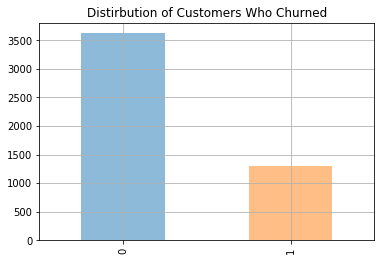

In [20]:
train_df.churn.value_counts().sort_index().plot(kind = "bar",alpha = .5)
plt.title("Distirbution of Customers Who Churned")
plt.grid(b = True , which = "major")

### Continuous Variables

In [21]:
xcols_continuous = ['monthly_charges', 'total_charges', 'tenure_year']

/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


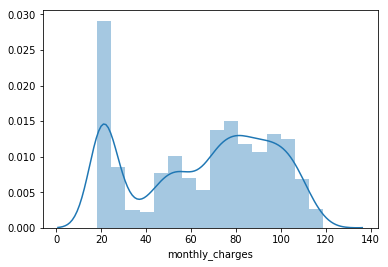

In [22]:
sns.distplot(train_df.monthly_charges)

In [23]:
#sns.distplot(train_df.total_charges)

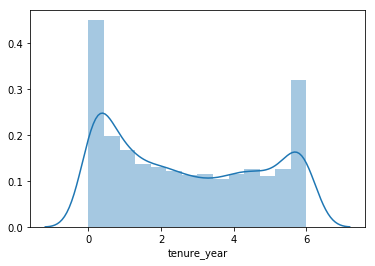

In [24]:
sns.distplot(train_df.tenure_year)

### Categorical Variables

In [25]:
xcols_categorical = ['gender', 'senior_citizen', 'internet_service_type_id',
                     'contract_type_id', 'paperless_billing', 'payment_type_id',
                     'phone_id', 'household_type_id', 'streaming_services',
                     'online_security_backup']

[]

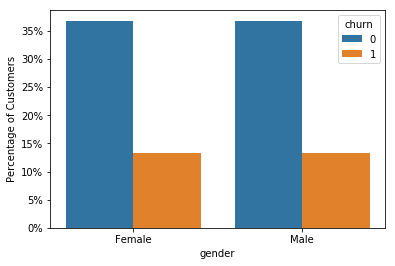

In [26]:
g = train_df.groupby('gender')['churn'].value_counts().to_frame()
g = g.rename({'churn': 'Percentage of Customers'}, axis=1).reset_index()
g['Percentage of Customers'] = g['Percentage of Customers']/len(train_df)
ax = sns.barplot(x='gender', y= 'Percentage of Customers', hue='churn', data=g, orient='v')
ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])
ax.plot()

[]

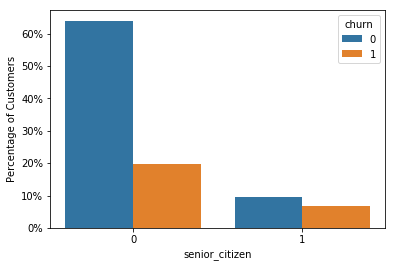

In [27]:
g = train_df.groupby('senior_citizen')['churn'].value_counts().to_frame()
g = g.rename({'churn': 'Percentage of Customers'}, axis=1).reset_index()
g['Percentage of Customers'] = g['Percentage of Customers']/len(train_df)
ax = sns.barplot(x='senior_citizen', y= 'Percentage of Customers', hue='churn', data=g, orient='v')
ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])
ax.plot()

[]

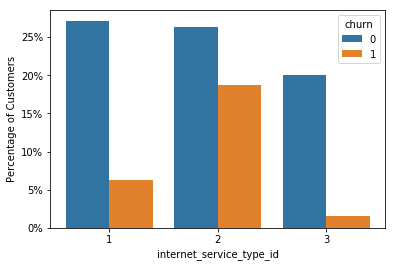

In [28]:
g = train_df.groupby('internet_service_type_id')['churn'].value_counts().to_frame()
g = g.rename({'churn': 'Percentage of Customers'}, axis=1).reset_index()
g['Percentage of Customers'] = g['Percentage of Customers']/len(train_df)
ax = sns.barplot(x='internet_service_type_id', y= 'Percentage of Customers', hue='churn', data=g, orient='v')
ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])
ax.plot()

[]

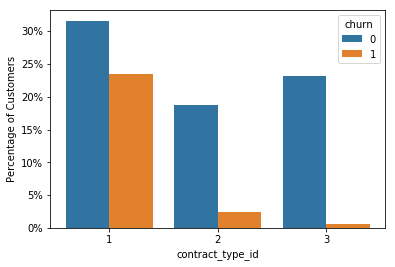

In [29]:
g = train_df.groupby('contract_type_id')['churn'].value_counts().to_frame()
g = g.rename({'churn': 'Percentage of Customers'}, axis=1).reset_index()
g['Percentage of Customers'] = g['Percentage of Customers']/len(train_df)
ax = sns.barplot(x='contract_type_id', y= 'Percentage of Customers', hue='churn', data=g, orient='v')
ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])
ax.plot()

[]

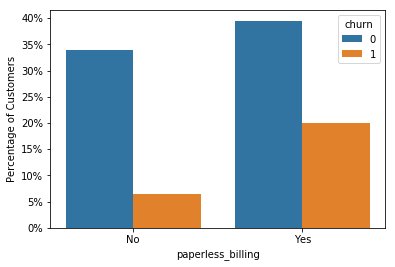

In [30]:
g = train_df.groupby('paperless_billing')['churn'].value_counts().to_frame()
g = g.rename({'churn': 'Percentage of Customers'}, axis=1).reset_index()
g['Percentage of Customers'] = g['Percentage of Customers']/len(train_df)
ax = sns.barplot(x='paperless_billing', y= 'Percentage of Customers', hue='churn', data=g, orient='v')
ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])
ax.plot()

[]

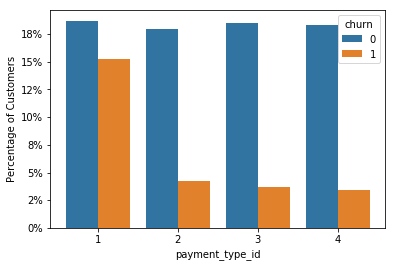

In [31]:
g = train_df.groupby('payment_type_id')['churn'].value_counts().to_frame()
g = g.rename({'churn': 'Percentage of Customers'}, axis=1).reset_index()
g['Percentage of Customers'] = g['Percentage of Customers']/len(train_df)
ax = sns.barplot(x='payment_type_id', y= 'Percentage of Customers', hue='churn', data=g, orient='v')
ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])
ax.plot()

[]

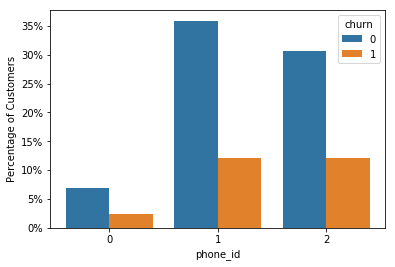

In [32]:
g = train_df.groupby('phone_id')['churn'].value_counts().to_frame()
g = g.rename({'churn': 'Percentage of Customers'}, axis=1).reset_index()
g['Percentage of Customers'] = g['Percentage of Customers']/len(train_df)
ax = sns.barplot(x='phone_id', y= 'Percentage of Customers', hue='churn', data=g, orient='v')
ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])
ax.plot()

[]

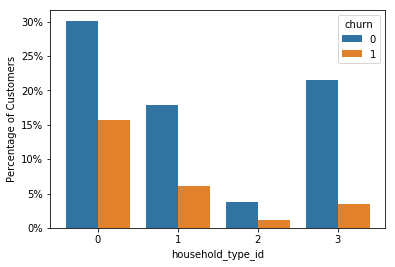

In [33]:
g = train_df.groupby('household_type_id')['churn'].value_counts().to_frame()
g = g.rename({'churn': 'Percentage of Customers'}, axis=1).reset_index()
g['Percentage of Customers'] = g['Percentage of Customers']/len(train_df)
ax = sns.barplot(x='household_type_id', y= 'Percentage of Customers', hue='churn', data=g, orient='v')
ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])
ax.plot()

[]

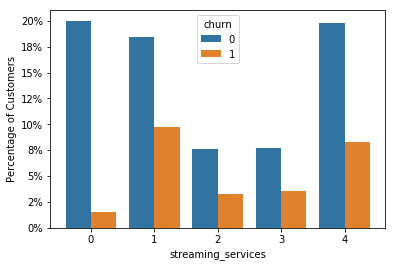

In [34]:
g = train_df.groupby('streaming_services')['churn'].value_counts().to_frame()
g = g.rename({'churn': 'Percentage of Customers'}, axis=1).reset_index()
g['Percentage of Customers'] = g['Percentage of Customers']/len(train_df)
ax = sns.barplot(x='streaming_services', y= 'Percentage of Customers', hue='churn', data=g, orient='v')
ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])
ax.plot()

[]

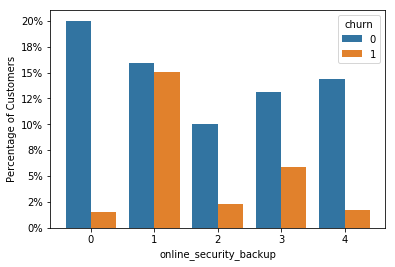

In [35]:
g = train_df.groupby('online_security_backup')['churn'].value_counts().to_frame()
g = g.rename({'churn': 'Percentage of Customers'}, axis=1).reset_index()
g['Percentage of Customers'] = g['Percentage of Customers']/len(train_df)
ax = sns.barplot(x='online_security_backup', y= 'Percentage of Customers', hue='churn', data=g, orient='v')
ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])
ax.plot()

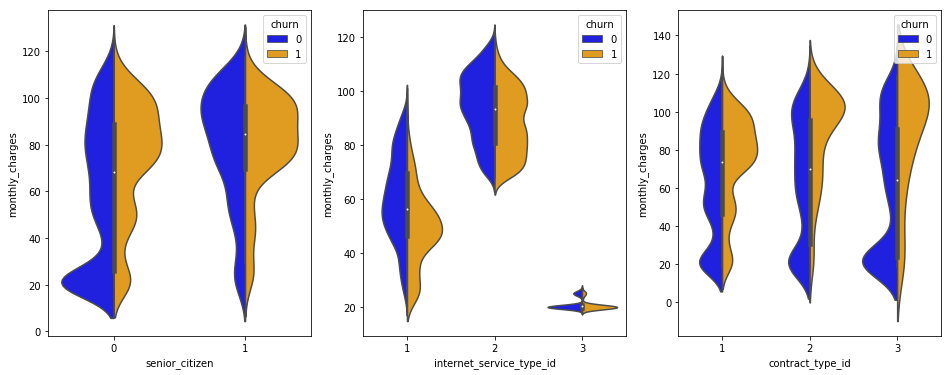

In [36]:
features = ['senior_citizen', 'internet_service_type_id', 'contract_type_id']
feature_count = range(len(features))

_, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,6))

for i, feature in enumerate(features):
    sns.violinplot(feature, 'monthly_charges', hue='churn',
        data=train_df, split=True, ax=ax[i], palette=['blue','orange'])

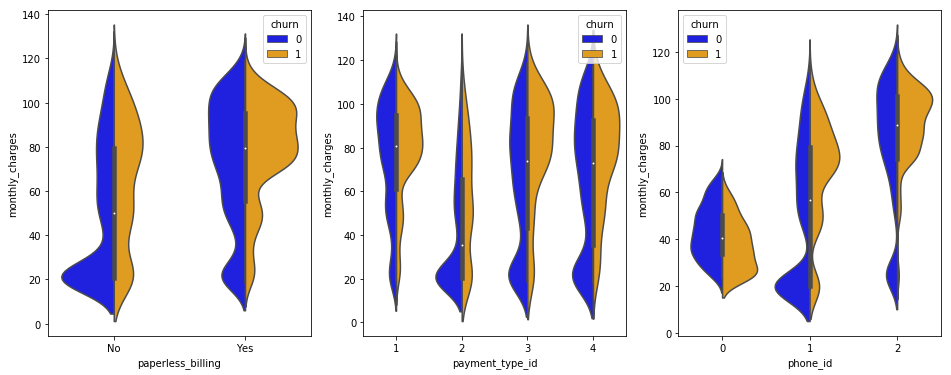

In [37]:
features = ['paperless_billing', 'payment_type_id', 'phone_id']
feature_count = range(len(features))

_, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,6))

for i, feature in enumerate(features):
    sns.violinplot(feature, 'monthly_charges', hue='churn',
        data=train_df, split=True, ax=ax[i], palette=['blue','orange'])

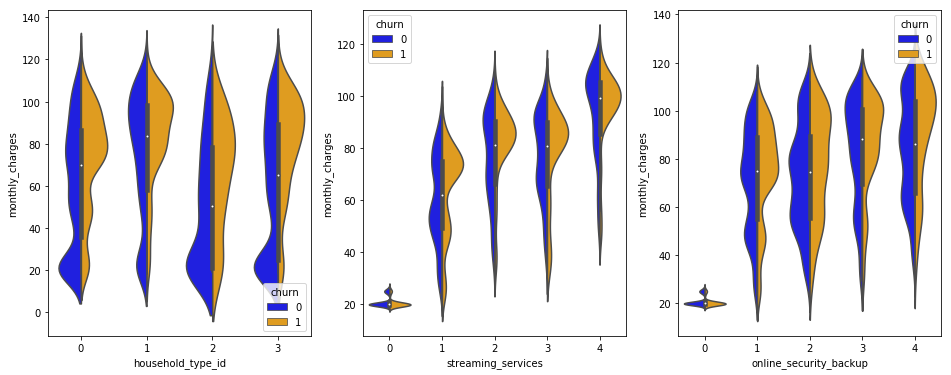

In [38]:
features = ['household_type_id', 'streaming_services',
                     'online_security_backup']
feature_count = range(len(features))

_, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,6))

for i, feature in enumerate(features):
    sns.violinplot(feature, 'monthly_charges', hue='churn',
        data=train_df, split=True, ax=ax[i], palette=['blue','orange'])

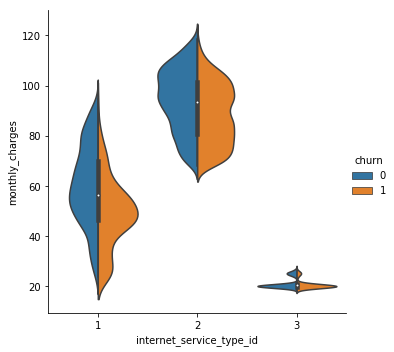

In [39]:
ax = sns.catplot(x="internet_service_type_id", y="monthly_charges", hue="churn", kind="violin", split=True, data=train_df)

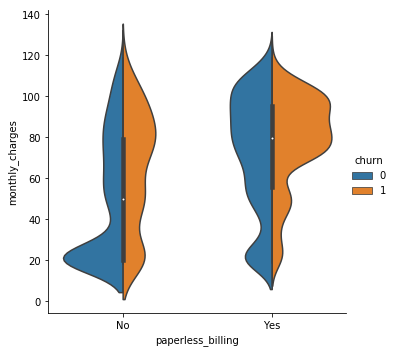

In [40]:
ax = sns.catplot(x="paperless_billing", y="monthly_charges", hue="churn", kind="violin", split=True, data=train_df)

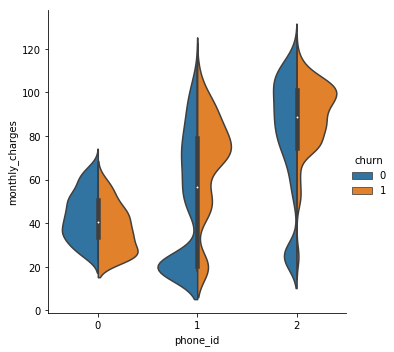

In [41]:
ax = sns.catplot(x="phone_id", y="monthly_charges", hue="churn", kind="violin", split=True, data=train_df)

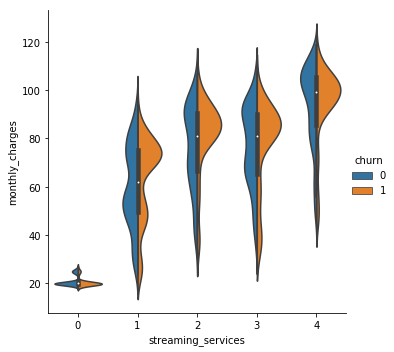

In [42]:
ax = sns.catplot(x="streaming_services", y="monthly_charges", hue="churn", kind="violin", split=True, data=train_df)

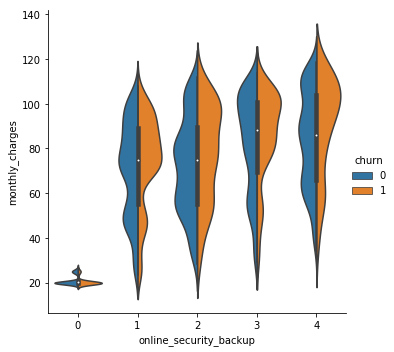

In [43]:
ax = sns.catplot(x="online_security_backup", y="monthly_charges", hue="churn", kind="violin", split=True, data=train_df)

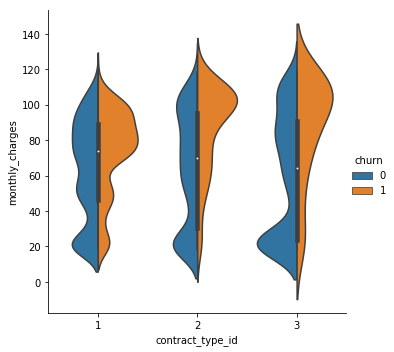

In [44]:
ax = sns.catplot(x="contract_type_id", y="monthly_charges", hue="churn", kind="violin", split=True, data=train_df)

In [45]:
sp.stats.ttest_ind(
    train_df[train_df.churn == 1].monthly_charges.dropna(),
    train_df[train_df.churn == 0].monthly_charges.dropna())

# is the t-statistic < -1.96 or > 1.96?  if so, then look at p-value to ensure it is less than our alpha of .05.

Ttest_indResult(statistic=13.771646316787574, pvalue=2.2795072811413085e-42)

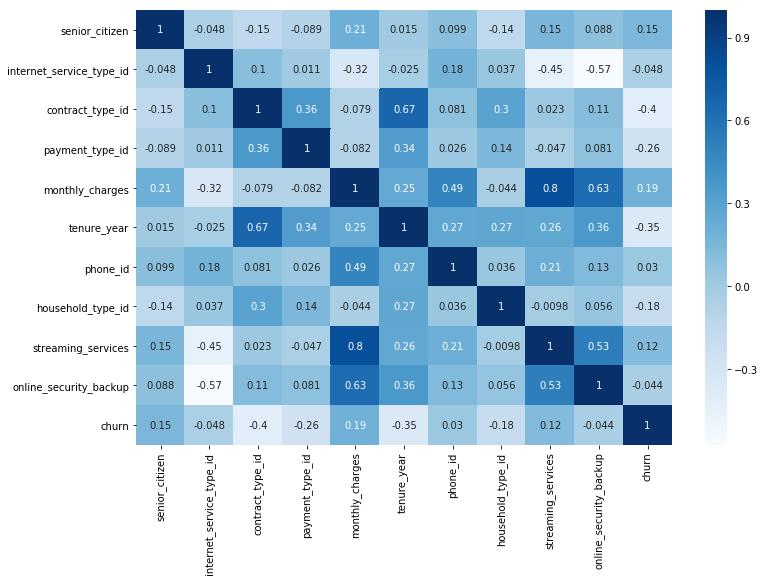

In [46]:
plt.figure(figsize=(12,8))
sns.heatmap(train_df.corr(), cmap='Blues', annot=True)

In [47]:
pd.crosstab(train_df.internet_service_type_id, train_df.churn, margins=True).style.background_gradient(cmap='YlOrRd')

churn,0,1,All
internet_service_type_id,,,
1,1338,308,1646
2,1298,923,2221
3,986,77,1063
All,3622,1308,4930


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead
  after removing the cwd from sys.path.


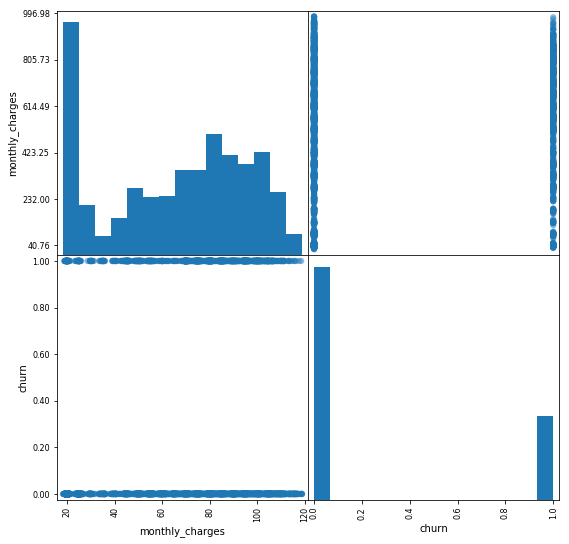

In [48]:
cmap = cm.get_cmap('gnuplot')
axes = pd.scatter_matrix(
    train_df[['monthly_charges', 'total_charges', 'churn']], marker='o', s=40,
    hist_kwds={'bins':15},  figsize=(9,9), cmap=cmap)
for ax in axes.flatten():
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    

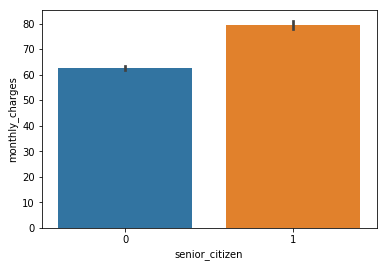

In [49]:
ax = sns.barplot(x="senior_citizen", y="monthly_charges", data=train_df)

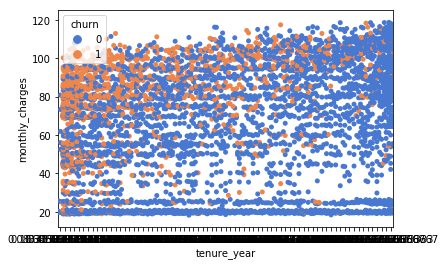

In [52]:
ax = sns.swarmplot(x="tenure_year", y="monthly_charges", hue="churn", data=train_df, palette="muted")

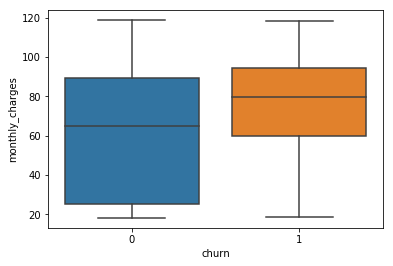

In [53]:
ax = sns.boxplot(x='churn', y='monthly_charges', data=train_df)

In [54]:
# g = sns.pairplot(train_df)

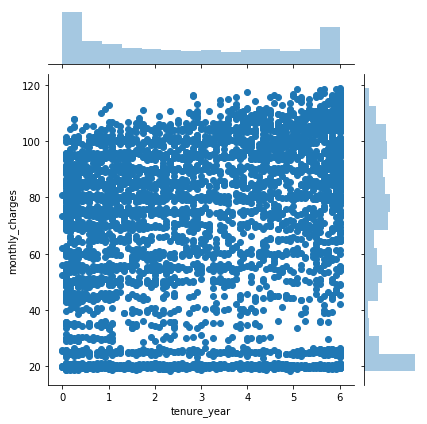

In [55]:
g = sns.jointplot(x="tenure_year", y="monthly_charges", data=train_df)

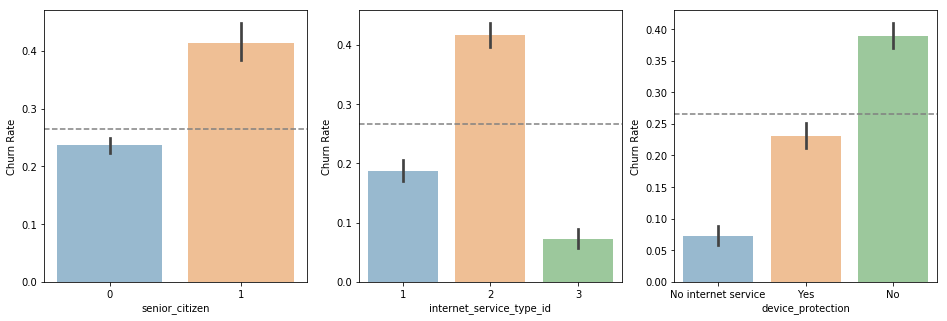

In [76]:
features = ['senior_citizen', 'internet_service_type_id', 'device_protection']

_, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,5))

churn_rate = train_df.churn.mean()

for i, feature in enumerate(features):
    sns.barplot(feature, 'churn', data=train_df, ax=ax[i], alpha=.5)
    ax[i].set_ylabel('Churn Rate')
    ax[i].axhline(churn_rate, ls='--', color='grey')

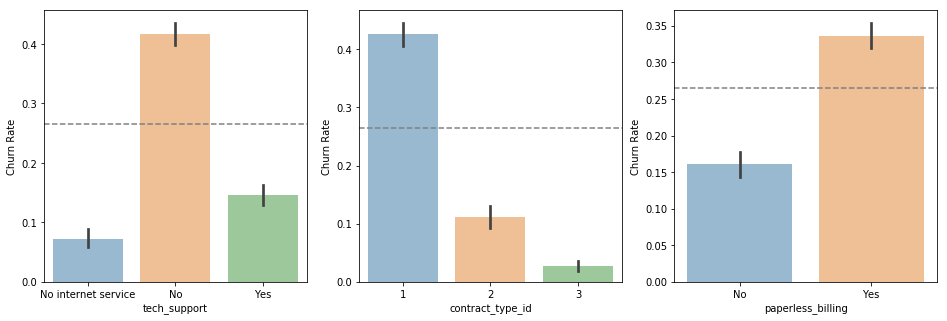

In [77]:
features = ['tech_support', 'contract_type_id', 'paperless_billing']

_, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,5))

churn_rate = train_df.churn.mean()

for i, feature in enumerate(features):
    sns.barplot(feature, 'churn', data=train_df, ax=ax[i], alpha=.5)
    ax[i].set_ylabel('Churn Rate')
    ax[i].axhline(churn_rate, ls='--', color='grey')

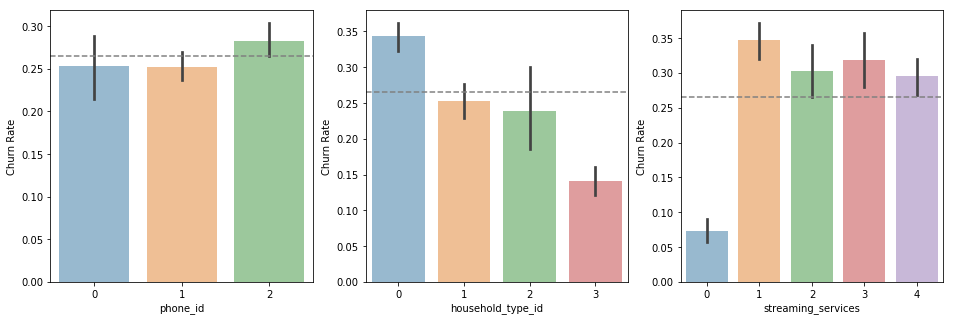

In [79]:
features = ['phone_id', 'household_type_id', 'streaming_services']

_, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,5))

churn_rate = train_df.churn.mean()

for i, feature in enumerate(features):
    sns.barplot(feature, 'churn', data=train_df, ax=ax[i], alpha=.5)
    ax[i].set_ylabel('Churn Rate')
    ax[i].axhline(churn_rate, ls='--', color='grey')

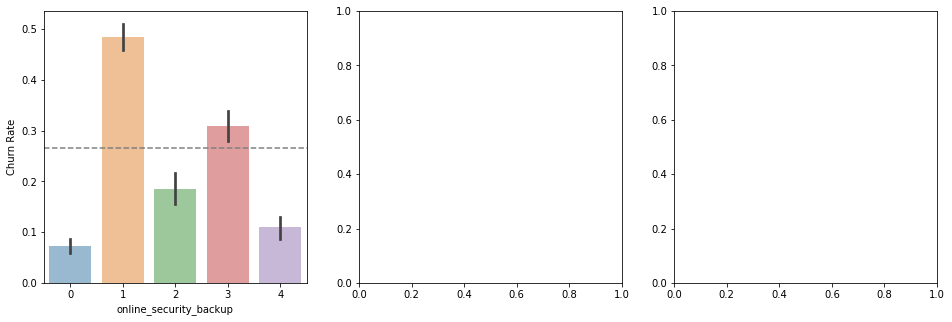

In [87]:
features = ['online_security_backup']

_, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,5))

churn_rate = train_df.churn.mean()

for i, feature in enumerate(features):
    sns.barplot(feature, 'churn', data=train_df, ax=ax[i], alpha=.5)
    ax[i].set_ylabel('Churn Rate')
    ax[i].axhline(churn_rate, ls='--', color='grey')

## Modeling

1. Feature Selection: Are there any variables that seem to provide limited to no additional information? If so, remove those and assign the new limited dataframe to train_reduced

In [70]:
train_reduced = X_train.drop(columns=['gender', 'total_charges'])
train_reduced.head(10)






# 1. Make the thing
logit = LogisticRegression(C=1, class_weight={1:2}, random_state = 123, solver='saga')
# 2. Fit
logit.fit(train_reduced, y_train)
# 3. Do stuff
print('Coefficient: \n', logit.coef_)
print('Intercept: \n', logit.intercept_)

# Estimate whether a customer would churn
y_pred = logit.predict(train_reduced)

# Estimate the probability of a customer churning
y_pred_proba = logit.predict_proba(train_reduced)

# Model score
print(f'Accuracy of the Logistic Regression classifier on the\
        training set using \'SAGA\' as solver (model score):\
        {logit.score(train_reduced, y_train)}')

# Confusion matrix
print(confusion_matrix(y_train, y_pred))

cm = pd.DataFrame(confusion_matrix(y_train, y_pred),
                 columns=['Pred -', 'Pred +'], index=['Actual -', 'Actual +'])

# Classification report
print(classification_report(y_train, y_pred))


# TEST --------------------------

# Estimate whether a customer would churn
y_pred_test = logit.predict(X_test)

# Estimate the probability of a customer churning
y_pred_proba_test = logit.predict_proba(X_test)

# Model score
print(f'Accuracy of the Logistic Regression classifier on\
        test set (Model Score):\
        {logit.score(X_test, y_test)}')

# Confusion matrix
print(confusion_matrix(y_train, y_pred))

cm = pd.DataFrame(confusion_matrix(y_test, y_pred_test),
                 columns=['Pred -', 'Pred +'], index=['Actual -', 'Actual +'])

# Classification report
print(classification_report(y_test, y_pred_test))


Coefficient: 
 [[ 0.31548738  0.01022179 -0.05454778 -0.32028534 -0.81071751  0.41328633
  -0.13979551  2.60994448 -1.89685695 -0.19146854 -0.08447528  0.06433699
  -0.17442277]]
Intercept: 
 [0.91876994]
Accuracy of the Logistic Regression classifier on the        training set using 'SAGA' as solver (model score):        0.7681541582150101
[[2831  791]
 [ 352  956]]
              precision    recall  f1-score   support

           0       0.89      0.78      0.83      3622
           1       0.55      0.73      0.63      1308

   micro avg       0.77      0.77      0.77      4930
   macro avg       0.72      0.76      0.73      4930
weighted avg       0.80      0.77      0.78      4930



/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ValueError: X has 15 features per sample; expecting 13

In [73]:
# 1. Make the thing
logit = LogisticRegression(C=1, class_weight='balanced', random_state = 123, solver='saga')
# 2. Fit
logit.fit(X_train, y_train)
# 3. Do stuff
print('Coefficient: \n', logit.coef_)
print('Intercept: \n', logit.intercept_)

# Estimate whether a customer would churn
y_pred = logit.predict(X_train)

# Estimate the probability of a customer churning
y_pred_proba = logit.predict_proba(X_train)

# Model score
print(f'Accuracy of the Logistic Regression classifier on the\
        training set using \'SAGA\' as solver (model score):\
        {logit.score(X_train, y_train)}')

# Confusion matrix
print(confusion_matrix(y_train, y_pred))

cm = pd.DataFrame(confusion_matrix(y_train, y_pred),
                 columns=['Pred -', 'Pred +'], index=['Actual -', 'Actual +'])

# Classification report
print(classification_report(y_train, y_pred))


# TEST --------------------------

# Estimate whether a customer would churn
y_pred_test = logit.predict(X_test)

# Estimate the probability of a customer churning
y_pred_proba_test = logit.predict_proba(X_test)

# Model score
print(f'Accuracy of the Logistic Regression classifier on\
        test set (Model Score):\
        {logit.score(X_test, y_test)}')

# Confusion matrix
print(confusion_matrix(y_train, y_pred))

cm = pd.DataFrame(confusion_matrix(y_test, y_pred_test),
                 columns=['Pred -', 'Pred +'], index=['Actual -', 'Actual +'])

# Classification report
print(classification_report(y_test, y_pred_test))

Coefficient: 
 [[ 0.0106085   0.31719434 -0.02022194 -0.06937195 -0.32457878 -0.82843363
   0.40955439 -0.13765466  2.33696618  1.3376975  -2.66476243 -0.21028615
  -0.08463177  0.05951362 -0.18443651]]
Intercept: 
 [1.47270031]
Accuracy of the Logistic Regression classifier on the        training set using 'SAGA' as solver (model score):        0.740973630831643
[[2595 1027]
 [ 250 1058]]
              precision    recall  f1-score   support

           0       0.91      0.72      0.80      3622
           1       0.51      0.81      0.62      1308

   micro avg       0.74      0.74      0.74      4930
   macro avg       0.71      0.76      0.71      4930
weighted avg       0.80      0.74      0.76      4930

Accuracy of the Logistic Regression classifier on        test set (Model Score):        0.7434926644581165
[[2595 1027]
 [ 250 1058]]
              precision    recall  f1-score   support

           0       0.91      0.72      0.81      1552
           1       0.51      0.80    

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [69]:
train_reduced.head(10)

,senior_citizen,internet_service_type_id,device_protection,tech_support,contract_type_id,paperless_billing,payment_type_id,monthly_charges,tenure_year,phone_id,household_type_id,streaming_services,online_security_backup
4953,0,3,1,1,2,0,1,0.014428,0.763889,1,1,0,0
534,1,2,2,0,2,0,3,0.894030,0.916667,2,0,4,3
172,0,1,0,2,3,0,3,0.321393,0.916667,0,3,4,1
3710,0,3,1,1,3,1,3,0.057214,0.944444,2,3,0,0
1574,0,2,2,0,2,1,4,0.820896,0.791667,2,1,4,1
5931,0,1,0,0,1,1,1,0.266169,0.013889,1,1,1,1
3558,0,2,0,0,1,1,3,0.506965,0.097222,1,1,1,1
4949,0,1,0,0,2,1,4,0.266169,0.805556,0,1,4,1
4447,0,2,2,0,2,0,4,0.771144,0.958333,2,3,2,3
135,0,1,2,2,1,0,1,0.410945,0.263889,2,0,1,1


2. Train (fit, transform, evaluate) a logistic regression model varying your meta-parameters.

3. Compare evaluation metrics across all the models, and select the best performing model.

4. Test the final model (transform, evaluate) on your out-of-sample data (test_df). Summarize the performance. Interpret your results.

# Delivery

1. I will need you to deliver to me a csv with the customer_id, probability of churn, and the prediction of churn (1=churn, 0=not_churn). I would also like a single google slide that illustrates how your model works, including the features being used, so that I can deliver this to the SLT when they come with questions about how these values were derived. Please make sure you include how likely your model is to give a high probability of churn when churn doesn't occur, to give a low probability of churn when churn occurs, and to accurately predict churn.

1. Finally, our development team will need a .py file that will take in a new dataset, (in the exact same form of the one you acquired from telco_churn.customers) and perform all the transformations necessary to run the model you have developed on this new dataset to provide probabilities and predictions.